# Titanic Dataset - Feature Engineering Analysis

> **Author:** Arthur Gislon Leonida  
> **Course:** Algoritmos e Estruturas de Dados - UFSC  
> **Objective:** Predict passenger survival on the Titanic using advanced feature engineering techniques

---

## Dataset Overview

**Source:** [Kaggle Titanic Competition](https://www.kaggle.com/competitions/titanic)

### Target Variable
- **`Survived`:** Survival status (0 = No, 1 = Yes)

### Feature Dictionary

| Feature | Description | Type |
|---------|-------------|------|
| **pclass** | Ticket class (1st, 2nd, 3rd) | Categorical |
| **sex** | Gender | Categorical |
| **age** | Age in years | Numerical |
| **sibsp** | Number of siblings/spouses aboard | Numerical |
| **parch** | Number of parents/children aboard | Numerical |
| **ticket** | Ticket number | Text |
| **fare** | Passenger fare | Numerical |
| **cabin** | Cabin number | Text |
| **embarked** | Port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton) | Categorical |

---

## Analysis Workflow

1. **Environment Setup & CUDA Configuration**
2. **Data Loading & Exploration**
3. **Baseline Model Development**
4. **Feature Engineering Pipeline**
5. **Advanced Feature Selection**
6. **Model Comparison & Optimization**

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Advanced Analysis
import shap
import optuna as opt
from scipy.stats import boxcox
from helper_functions import robust_outlier_detection, hsic_from_scratch, OptimalMIEstimator

# Configuration
set_config(transform_output="pandas")
np.random.seed(42)

# Version Information
print("Library Versions:")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")
print(f"   sklearn: {sklearn.__version__}")

print(f"   xgboost: {xgb.__version__}")
print(f"   python: {os.popen('python --version').read().strip()}")

print(f"   shap: {shap.__version__}")
print(f"   optuna: {opt.__version__}")

Library Versions:
   pandas: 2.3.2
   numpy: 2.2.0
   sklearn: 1.7.1
   xgboost: 3.0.4
   python: Python 3.13.7
   shap: 0.48.0
   optuna: 4.5.0


In [2]:
features_description = {
    'PassengerId': 'Passenger ID',
    'Survived': 'Survival (0 = No; 1 = Yes)',
    'Pclass': 'Passenger Class (1st, 2nd, 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age in years',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

In [3]:
# Load dataset
train_file_path = 'data/train.csv'
df = pd.read_csv(train_file_path)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])

print(f"Dataset loaded: {len(df)} total samples")
print(f"Training: {len(df_train)} samples")
print(f"Validation: {len(df_val)} samples")

# Display basic info
print(f"\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"Survival rate: {df['Survived'].mean():.1%}")

df.head()

Dataset loaded: 891 total samples
Training: 712 samples
Validation: 179 samples

Dataset Info:
Shape: (891, 12)
Survival rate: 38.4%


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Missing values analysis
missing_info = df.isnull().sum()
missing_pct = (missing_info / len(df) * 100).round(1)

print("Missing Values Analysis:")
for col, count in missing_info.items():
    if count > 0:
        pct = missing_pct[col]
        print(f"{col}: {count} ({pct}%)")

missing_info[missing_info > 0]

Missing Values Analysis:
Age: 177 (19.9%)
Cabin: 687 (77.1%)
Embarked: 2 (0.2%)


Age         177
Cabin       687
Embarked      2
dtype: int64

## Baseline Model Development

### Preprocessing Strategy
Creating a simple preprocessing pipeline without extensive feature engineering to establish a performance baseline.

**Approach:**
- **Numerical features:** Mean imputation
- **Categorical features:** Most frequent imputation + One-hot encoding
- **Dropped features:** Name, Ticket, Cabin (high cardinality/text data)

In [5]:
# 1. Define which columns are which type
numeric_features = []
categorical_features = []
for col in df_train.drop('Survived', axis=1).columns:
    # check col type
    if df_train[col].dtype == 'object':
        categorical_features.append(col)
    else:    
        numeric_features.append(col)

# 2. Create the preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # This ensures columns like 'Name', 'Ticket', and 'Cabin' are dropped
)

# 4. Create the final, simple baseline pipeline
baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

### Baseline Model Training

Training an XGBoost classifier with default parameters on the preprocessed features.

In [6]:
X_train_base = df_train.drop('Survived', axis=1)
y_train_base = df_train['Survived']
X_val_base = df_val.drop('Survived', axis=1)
y_val_base = df_val['Survived']

X_train_base_processed = baseline_pipeline.fit_transform(X_train_base)
X_val_base_processed = baseline_pipeline.transform(X_val_base)

In [7]:
# Train baseline model
baseline_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
baseline_model.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model.predict(X_val_base_processed)
baseline_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

Baseline Model Accuracy: 0.7263


### Hyperparameter Optimization

Using **Optuna** for automated hyperparameter tuning to maximize model performance.

**Optimization Strategy:**
- **Objective:** Maximize cross-validated accuracy
- **Search space:** Learning rate, max depth, regularization parameters
- **Trials:** 200 iterations

In [ ]:
def objective_cv(trial, X_train, y_train):
    """
    Cross-validation objective function for more robust hyperparameter optimization.
    Enhanced with stronger regularization to prevent overfitting.
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),  # Lower max
        'max_depth': trial.suggest_int('max_depth', 3, 6),  # Reduced max depth
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Added regularization
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Reduced max
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),  # Reduced max
        'gamma': trial.suggest_float('gamma', 0, 3),  # Reduced range
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 20),  # Increased regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    
    # Use 5-fold cross-validation for more robust evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return -cv_scores.mean()

In [9]:
study = opt.create_study(direction='minimize')
study.optimize(
    lambda trial: objective_cv(
        trial, X_train_base_processed, y_train_base
    ), 
    n_trials=200
)

print("\nBest hyperparameters found:")
print(study.best_params)

print("\nBest CV Accuracy on the training set:")
print(f"{-study.best_value:.4f}")

[I 2025-09-29 22:18:48,593] A new study created in memory with name: no-name-a766ca30-6509-454d-806a-071e05cc6985
[I 2025-09-29 22:18:54,235] Trial 0 finished with value: -0.7851472471190781 and parameters: {'n_estimators': 50, 'learning_rate': 0.06153030570703114, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.752078671832312, 'colsample_bytree': 0.8386090648274689, 'gamma': 2.643653136928746, 'reg_lambda': 1.8617458788445207, 'reg_alpha': 9.630785740837013}. Best is trial 0 with value: -0.7851472471190781.
[I 2025-09-29 22:18:59,029] Trial 1 finished with value: -0.7977740569289865 and parameters: {'n_estimators': 200, 'learning_rate': 0.04554779081804702, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7540861076763041, 'colsample_bytree': 0.6824261972426251, 'gamma': 1.7687874586766419, 'reg_lambda': 13.31733134587918, 'reg_alpha': 2.662442168908864}. Best is trial 1 with value: -0.7977740569289865.
[I 2025-09-29 22:19:01,490] Trial 2 finished with value: -0.7893627499


Best hyperparameters found:
{'n_estimators': 50, 'learning_rate': 0.12769718901120092, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.745840613729814, 'colsample_bytree': 0.6181683483761774, 'gamma': 0.7084480141777753, 'reg_lambda': 2.4549042727841464, 'reg_alpha': 1.0997965639345204}

Best CV Accuracy on the training set:
0.8231


In [10]:
# Train baseline model with best hyperparameters from Optuna study
baseline_model_tuned = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    min_child_weight=study.best_params.get('min_child_weight', 3),  # Default regularization
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    reg_lambda=study.best_params['reg_lambda'],
    reg_alpha=study.best_params['reg_alpha'],
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10  # Add early stopping
)

baseline_model_tuned.fit(
    X_train_base_processed, y_train_base,
    eval_set=[(X_val_base_processed, y_val_base)],
    verbose=False
)

# Evaluate baseline model using the same data format as training/validation
preds_base = baseline_model_tuned.predict(X_val_base_processed)
baseline_tuned_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Tuned Model Accuracy: {baseline_tuned_accuracy:.4f}")

Baseline Tuned Model Accuracy: 0.8156


### Feature Importance Analysis

Using **SHAP (SHapley Additive exPlanations)** to understand which features contribute most to model predictions.

**SHAP Benefits:**
- Model-agnostic explanations  
- Individual prediction breakdowns
- Global feature importance ranking

**GPU Optimization (RTX 3050):**
- **Automatic GPU acceleration** when CUDA extensions are properly installed
- **Fallback to CPU** if GPU support is not available
- **Enhanced performance** for large datasets and SHAP analysis
- **Installation guide** provided below if CUDA support is missing


SHAP with Baseline Model Summary Plot:


C:\Users\arthu\AppData\Local\Temp\ipykernel_12996\4171717839.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)


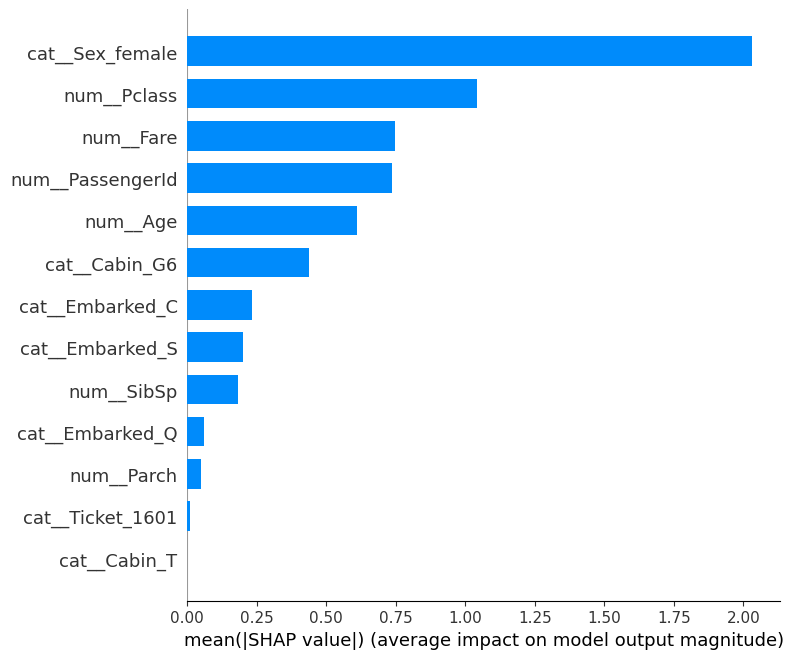

In [11]:
explainer = shap.Explainer(baseline_model, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)


SHAP with Tuned Baseline Model Summary Plot:


C:\Users\arthu\AppData\Local\Temp\ipykernel_12996\2367076036.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)


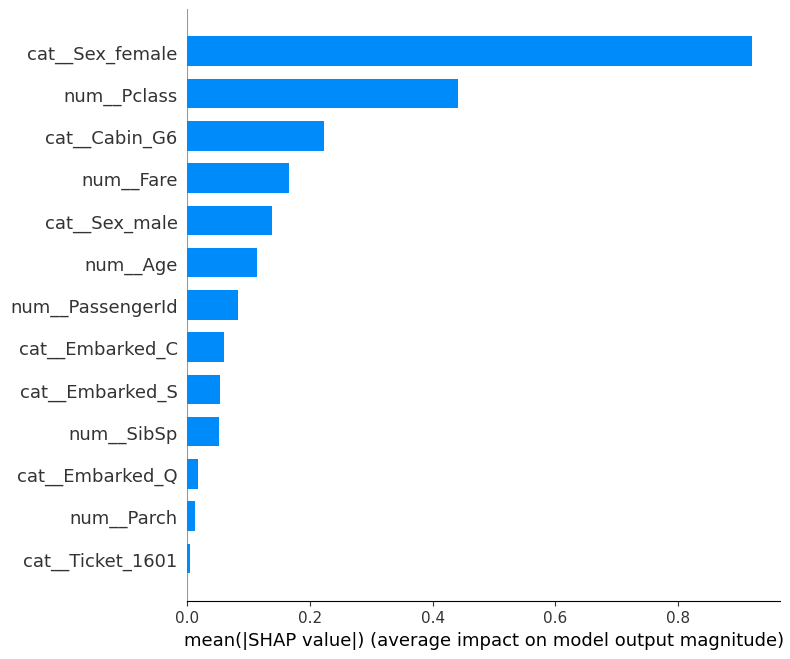

In [12]:
explainer = shap.Explainer(baseline_model_tuned, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Tuned Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)

# Advanced Feature Engineering Pipeline

## Custom Transformer Classes

Creating specialized preprocessing classes to extract maximum value from the raw data.

### Feature Engineering Strategies:

1. **Missing Value Imputation**
   - Age: Mean imputation
   - Embarked: Most frequent value

2. **Feature Creation**
   - Title extraction from names
   - Family size calculation
   - Cabin deck extraction
   - Alone passenger indicator

3. **Feature Encoding**
   - Label encoding for categorical variables
   - Preserving ordinal relationships

4. **Feature Selection**
   - Remove redundant/unhelpful columns

In [13]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
    
    def fit(self, X, y=None):
        self.imputer.fit(X[['Age']])
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Age'] = self.imputer.transform(X[['Age']])
        return X

class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
    
    def fit(self, X, y=None):
        self.imputer.fit(X[['Embarked']])
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Embarked'] = self.imputer.transform(X[['Embarked']])
        return X

class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
        X['Title'] = X['Title'].apply(lambda x: x if x in common_titles else 'Other')
        return X

class FamilyFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Create the FamilySize feature
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        
        # Create the IsAlone feature
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        
        return X

class CabinExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Fill missing cabins with 'U' for 'Unknown'
        cabins = X['Cabin'].fillna('U')
        
        # Extract the first letter as Cabin Deck
        X['CabinDeck'] = cabins.str[0]
        
        # Count the number of cabins
        X['CabinCount'] = X['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.embarked_mapping = None
        self.sex_mapping = None
        self.title_mapping = None
        self.cabin_deck_mapping = None
    
    def fit(self, X, y=None):
        self.embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
        self.sex_mapping = {'female': 0, 'male': 1}
        self.title_mapping = {'Miss': 0, 'Mr': 1, 'Mrs': 2, 'Master': 3, 'Other': 4}
        
        # Learn cabin deck mapping from training data
        unique_decks = X['CabinDeck'].unique()
        self.cabin_deck_mapping = {deck: idx for idx, deck in enumerate(unique_decks)}
        return self

    def transform(self, X):
        X = X.copy()
        # Encode features using learned mappings
        X['Embarked'] = X['Embarked'].map(self.embarked_mapping)
        X['Sex'] = X['Sex'].map(self.sex_mapping)
        X['Title'] = X['Title'].map(self.title_mapping)
        X['CabinDeck'] = X['CabinDeck'].map(self.cabin_deck_mapping)
        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    """Applies StandardScaler to all numerical columns."""
    def __init__(self):
        self.scaler = StandardScaler()
        self.numerical_cols = []

    def fit(self, X, y=None):
        # Identify numerical columns to be scaled
        self.numerical_cols = X.drop('Survived', axis=1).select_dtypes(include=np.number).columns.tolist()
        if self.numerical_cols:
            self.scaler.fit(X[self.numerical_cols])
        return self

    def transform(self, X):
        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        return X.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, errors='ignore')

In [14]:
pipeline = Pipeline(steps=[
    # -- IMPUTATION --
    ('age_imputer', AgeImputer()),
    ('embarked_imputer', EmbarkedImputer()),
    # -- FEATURE CREATION (DATA AUGMENTATION) --
    ('family_feature_creator', FamilyFeatureCreator()),
    ('title_extractor', TitleExtractor()),
    ('cabin_extractor', CabinExtractor()),
  # -- ENCODING, SCALING AND DROPPING --
    ('feature_encoder', FeatureEncoder()),
    ('feature_scaler', FeatureScaler()),
    ('feature_dropper', FeatureDropper())
])

# Create copies for the next feature engineering steps
df_eng_train = df_train.copy()
df_eng_val = df_val.copy()

df_eng_train = pipeline.fit_transform(df_eng_train)
df_eng_val = pipeline.transform(df_eng_val)

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [15]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
df_eng_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount
692,1,0.829568,0.742427,-5.463229e-16,0.513812,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846
481,0,-0.370945,0.742427,-5.463229e-16,-0.662563,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846
527,0,-1.571457,0.742427,-5.463229e-16,3.955399,0.584892,-0.556339,0.800346,-0.145502,0.125445,1.420651
855,1,0.829568,-1.346933,-9.078708e-01,-0.467874,0.584892,0.073412,-1.249460,0.992932,-0.454533,-0.487846
801,1,-0.370945,-1.346933,9.167471e-02,-0.115977,0.584892,0.703162,-1.249460,0.992932,-0.454533,-0.487846


In [17]:
features = df_eng_train.drop(['Survived'], axis=1)
features.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount
692,0.829568,0.742427,-5.463229e-16,0.513812,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846
481,-0.370945,0.742427,-5.463229e-16,-0.662563,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846
527,-1.571457,0.742427,-5.463229e-16,3.955399,0.584892,-0.556339,0.800346,-0.145502,0.125445,1.420651
855,0.829568,-1.346933,-9.078708e-01,-0.467874,0.584892,0.073412,-1.249460,0.992932,-0.454533,-0.487846
801,-0.370945,-1.346933,9.167471e-02,-0.115977,0.584892,0.703162,-1.249460,0.992932,-0.454533,-0.487846


## Data Distribution Analysis

Visualizing the distribution of engineered features to understand data characteristics and identify potential issues.

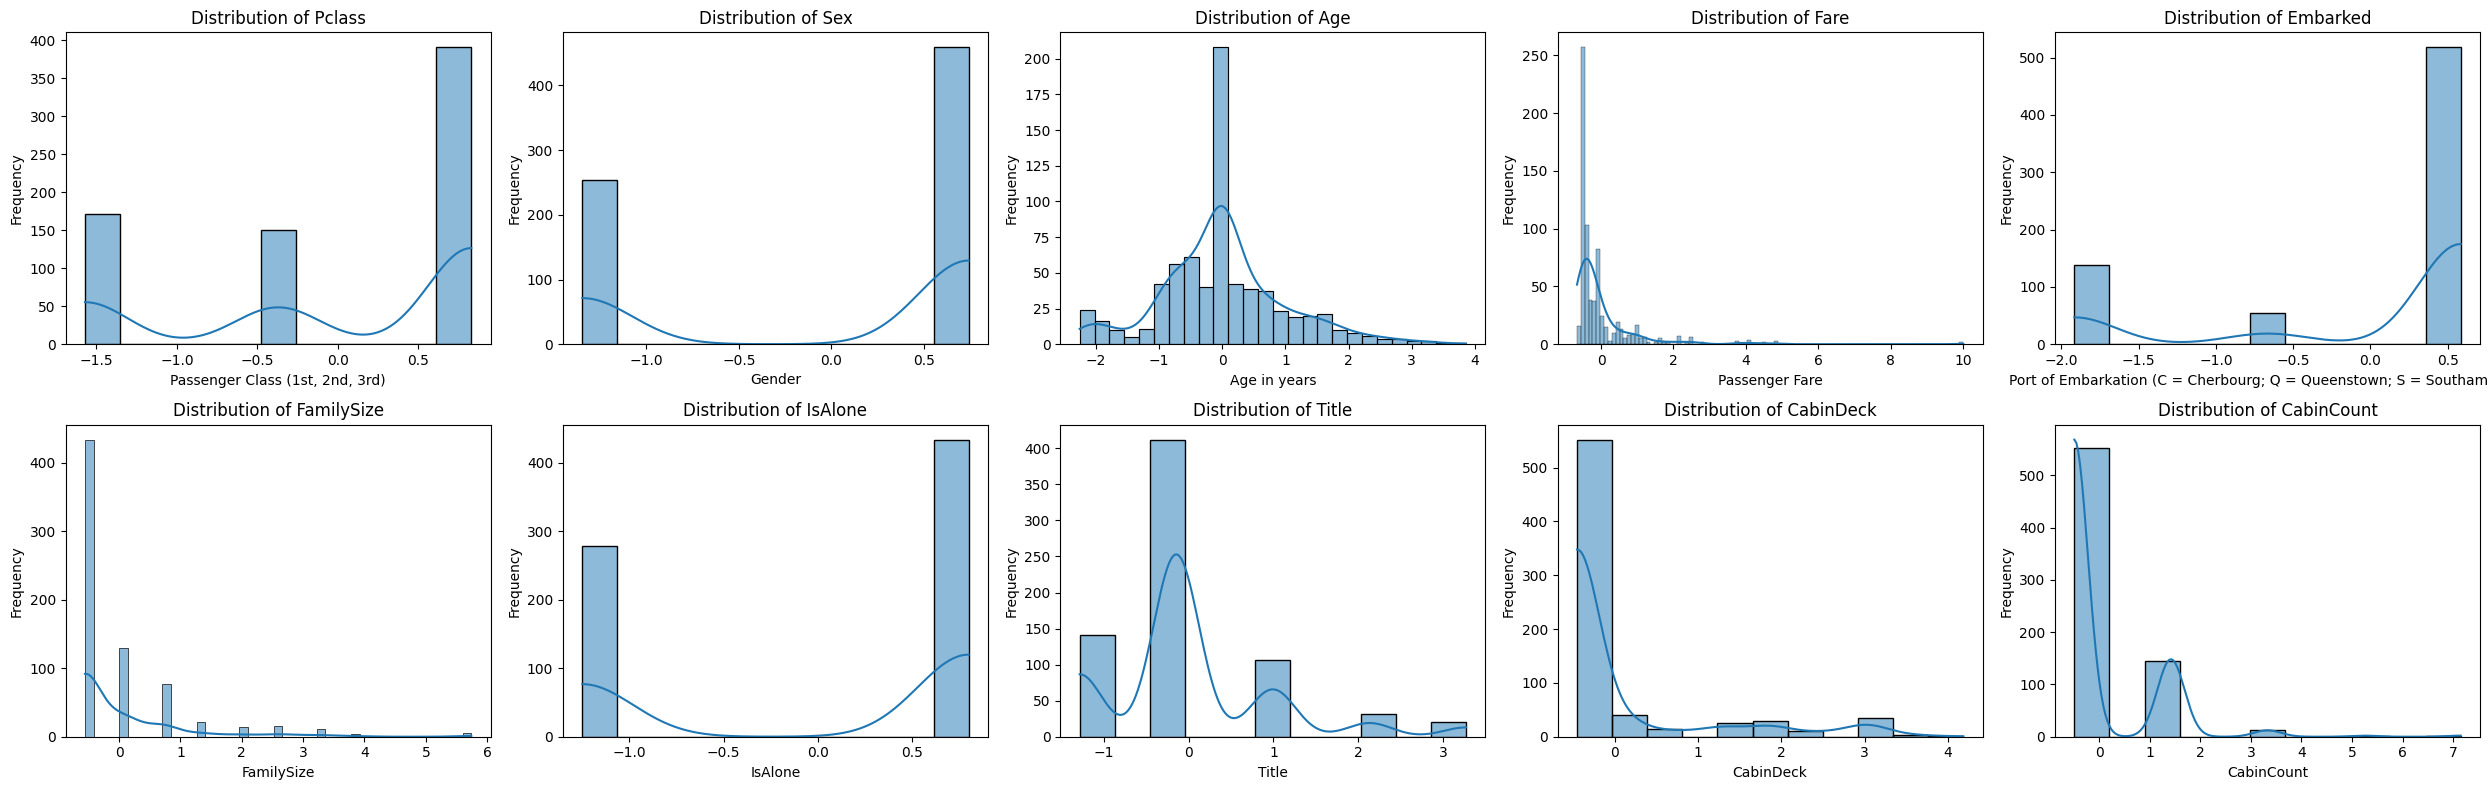

In [18]:
numeric_features = features.select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Skewness Assessment

Analyzing feature skewness to determine which variables need transformation for better model performance.

**Skewness Thresholds:**
- **|skew| > 1.5:** Highly skewed (requires transformation)
- **1.0 < |skew| ≤ 1.5:** Moderately skewed
- **|skew| ≤ 1.0:** Approximately normal

In [19]:
numerical_features = df_eng_train.select_dtypes(include=np.number).columns
skewness = df_eng_train[numerical_features].skew().sort_values(ascending=False)

print("Skewness of Numerical Features:")
print(skewness)

# Identify highly skewed features
highly_skewed = skewness[abs(skewness) > 0.5]
print("\nFeatures with significant skew:")
print(highly_skewed)

Skewness of Numerical Features:
Fare          4.646190
FamilySize    2.718601
CabinCount    2.545818
CabinDeck     2.195185
Title         1.181335
Survived      0.480519
Age           0.392903
IsAlone      -0.450063
Sex          -0.605783
Pclass       -0.630589
Embarked     -1.253597
dtype: float64

Features with significant skew:
Fare          4.646190
FamilySize    2.718601
CabinCount    2.545818
CabinDeck     2.195185
Title         1.181335
Sex          -0.605783
Pclass       -0.630589
Embarked     -1.253597
dtype: float64


In [20]:
highly_skewed_features = skewness[(abs(skewness) > 1.5)].index.tolist()
print("\nTop 3 highly skewed features:", highly_skewed_features)

moderate_skewed_features = skewness[(abs(skewness) > 1) & (abs(skewness) <= 1.5)].index.tolist()
print("\nModerately skewed features:", moderate_skewed_features)


Top 3 highly skewed features: ['Fare', 'FamilySize', 'CabinCount', 'CabinDeck']

Moderately skewed features: ['Title', 'Embarked']


In [21]:
for feature in numeric_features:
    print(f"Feature: {feature}, Min: {df_eng_train[feature].min()}, Max: {df_eng_train[feature].max()}, Skewness: {skewness[feature]}")

Feature: Pclass, Min: -1.571457222465138, Max: 0.8295675466232271, Skewness: -0.6305889933530607
Feature: Sex, Min: -1.3469332756346388, Max: 0.7424272739336898, Skewness: -0.6057829774753114
Feature: Age, Min: -2.259563928845463, Max: 3.859192464726948, Skewness: 0.39290325640922763
Feature: Fare, Min: -0.6625632269369692, Max: 10.005329337567716, Skewness: 4.646189951136251
Feature: Embarked, Min: -1.9162687925920723, Max: 0.5848923079130708, Skewness: -1.2535966557689557
Feature: FamilySize, Min: -0.5563385795422586, Max: 5.741166486182514, Skewness: 2.71860103565007
Feature: IsAlone, Min: -1.2494603151507815, Max: 0.800345547492897, Skewness: -0.45006349054333805
Feature: Title, Min: -1.2839358424880885, Max: 3.269799250172031, Skewness: 1.181335231356897
Feature: CabinDeck, Min: -0.4545330523408769, Max: 4.185288213131587, Skewness: 2.1951847557963107
Feature: CabinCount, Min: -0.4878462510362188, Max: 7.146143435508567, Skewness: 2.5458179262975293


### Skewness Correction Transformations

Applying appropriate transformations to reduce skewness and improve model performance.

**Transformation Strategy:**
- **Fare:** Box-Cox transformation (continuous, positive values)
- **Other skewed features:** Log1p transformation (handles zeros gracefully)

**Benefits:**
- Improved model convergence
- Better feature distribution
- Enhanced predictive power

In [22]:
# Apply Box-Cox transformation
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    """
    Applies the Box-Cox transformation to a list of specified numerical columns.
    """
    def __init__(self, features=None):
        # Store the list of feature names to be transformed
        self.features = features
        self.lambdas_ = {}

    def fit(self, X, y=None):
        # Learn the optimal lambda for each feature from the training data
        for feature in self.features:
            feature_data = X[feature] + 1  # Box-Cox requires positive values
            _, self.lambdas_[feature] = boxcox(feature_data)
        return self

    def transform(self, X):
        for feature in self.features:
            feature_data = X[feature] + 1
            # Apply the transformation using the lambda learned during fit
            X[feature] = boxcox(feature_data, lmbda=self.lambdas_[feature])
        return X

# Apply log1p transformation
def apply_log_transform(X):
    """Applies a log1p transformation."""
    return np.log1p(X)

In [23]:
features_to_bc_transform = ['Fare']
features_to_log_transform = ['FamilySize', 'CabinCount']

preprocessor = ColumnTransformer(
    transformers=[
        #('log_transformer', FunctionTransformer(apply_log_transform), features_to_log_transform),
        ('boxcox_transformer', BoxCoxTransformer(features=features_to_bc_transform), features_to_bc_transform)
    ],
    remainder='passthrough' # Keep other columns ('Age')
)

transform_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

df_eng_train = transform_pipeline.fit_transform(df_eng_train)
df_eng_val = transform_pipeline.transform(df_eng_val)

df_eng_train.columns = df_eng_train.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')
df_eng_val.columns = df_eng_val.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')

df_eng_train.head()

,boxcox_transformer_Fare,Survived,Pclass,Sex,Age,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount
692,0.336167,1,0.829568,0.742427,-5.463229e-16,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846
481,-2.027453,0,-0.370945,0.742427,-5.463229e-16,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846
527,0.775010,0,-1.571457,0.742427,-5.463229e-16,0.584892,-0.556339,0.800346,-0.145502,0.125445,1.420651
855,-0.894715,1,0.829568,-1.346933,-9.078708e-01,0.584892,0.073412,-1.249460,0.992932,-0.454533,-0.487846
801,-0.131605,1,-0.370945,-1.346933,9.167471e-02,0.584892,0.703162,-1.249460,0.992932,-0.454533,-0.487846


### Post-Transformation Visualization

Comparing feature distributions after applying skewness corrections to validate transformation effectiveness.

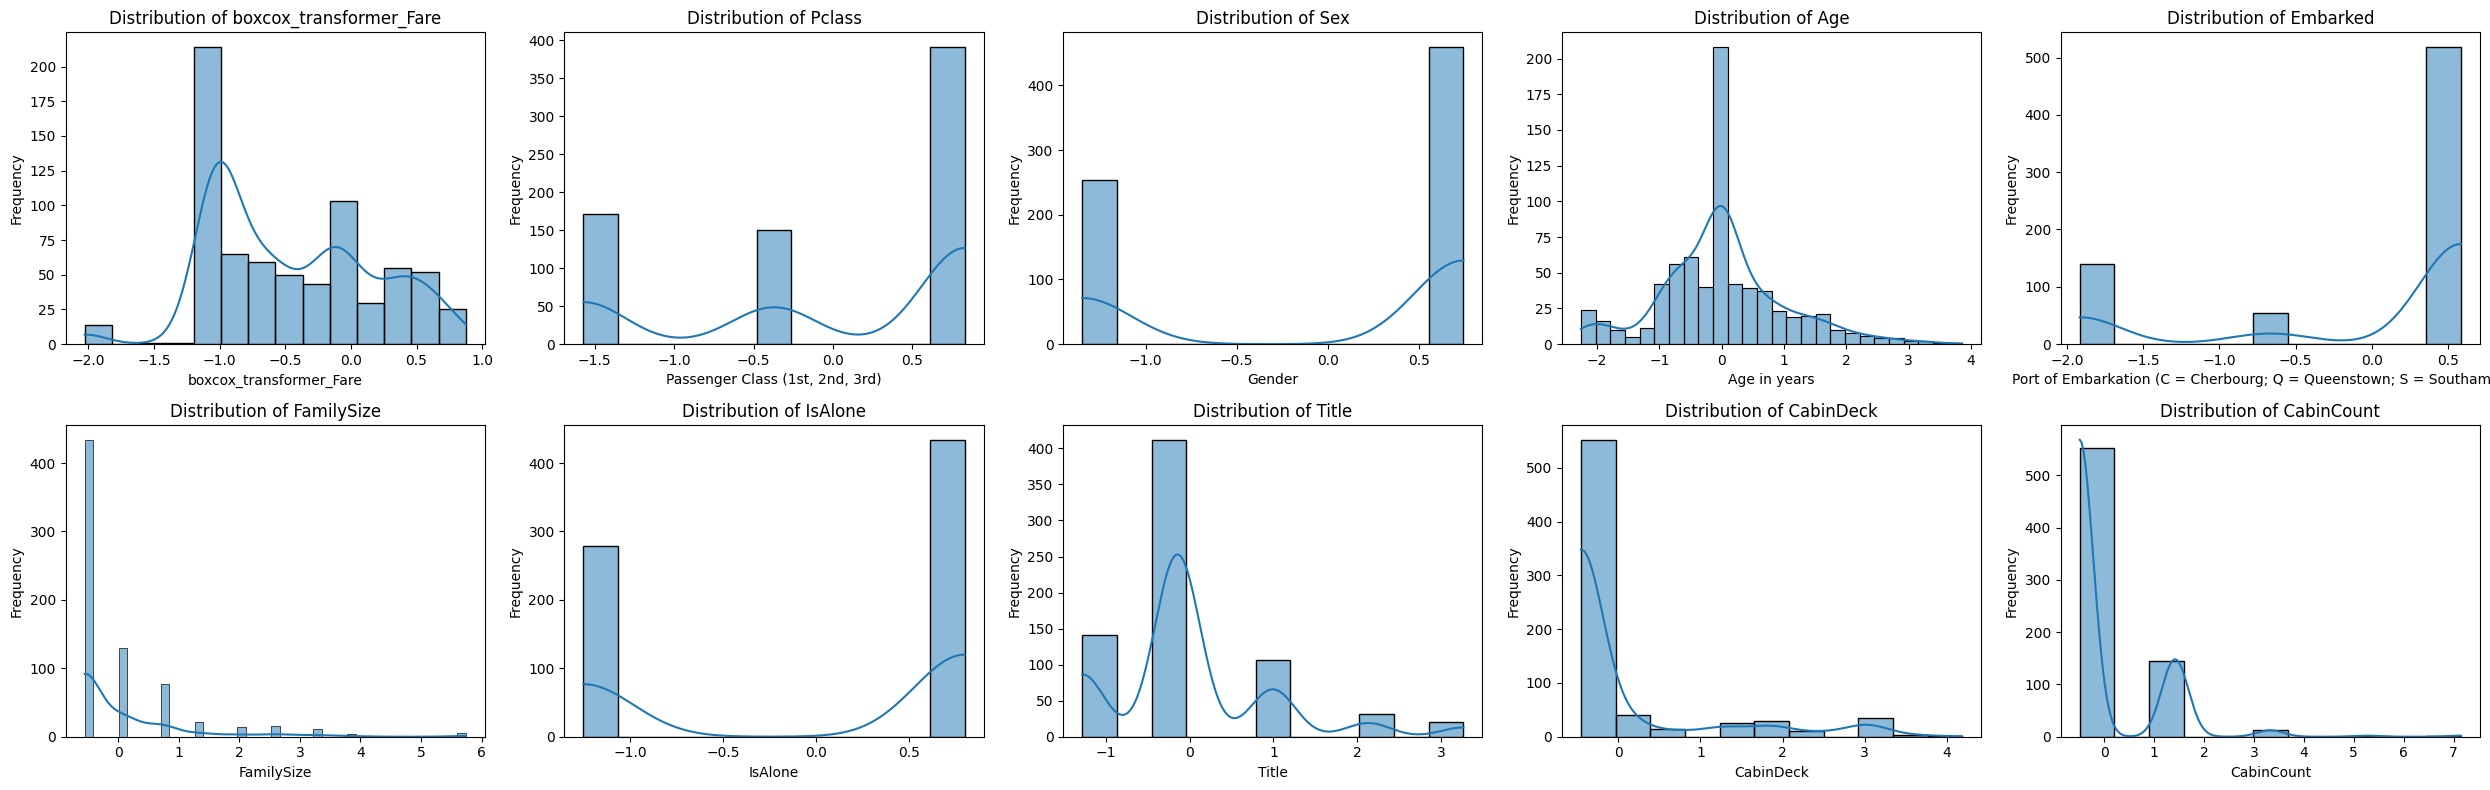

In [24]:
numeric_features = df_eng_train.drop(columns=['Survived']).select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Outlier Detection & Treatment

Using robust statistical methods to identify and handle outliers that could negatively impact model performance.

**Method:** Interquartile Range (IQR) with Winsorization
- **Detection:** Values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR
- **Treatment:** Cap extreme values at fence boundaries

In [25]:
for feature in df_eng_train.drop('Survived', axis=1).select_dtypes(include=['number']).columns:
    # print(f"Processing feature: {feature}")
    outliers = robust_outlier_detection(df_eng_train[feature])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        print(f'Feature "{feature}" has {num_outliers} outliers detected.')

Feature "Age" has 29 outliers detected.
Feature "FamilySize" has 72 outliers detected.
Feature "Title" has 21 outliers detected.
Feature "CabinDeck" has 39 outliers detected.
Feature "CabinCount" has 16 outliers detected.


### Winsorization Application

**Target Features:** Continuous variables only
- `boxcox_transformer_Fare`: Transformed fare values
- `Age`: Passenger age

**Rationale:** Winsorization preserves data distribution while removing extreme outliers that could skew model predictions.

Capping 'boxcox_transformer_Fare' at fences: [-2.50, 1.47]
Capping 'Age' at fences: [-2.21, 2.09]


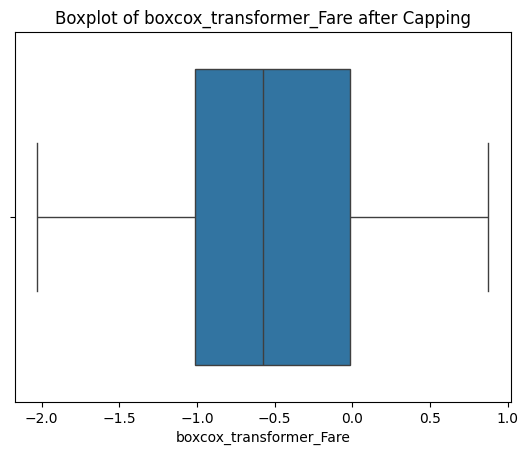

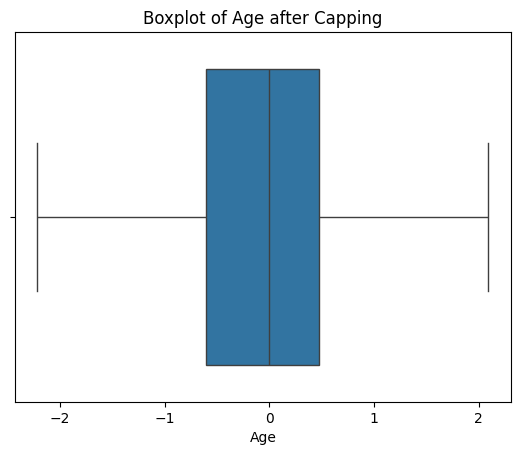

In [26]:
# Focus on the true numerical/continuous features from the list.
features_to_cap = ['boxcox_transformer_Fare', 'Age']

for feature in features_to_cap:
    if feature in df_eng_train.columns:
        # Define bounds using ONLY the training data
        Q1 = df_eng_train[feature].quantile(0.25)
        Q3 = df_eng_train[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        print(f"Capping '{feature}' at fences: [{lower_fence:.2f}, {upper_fence:.2f}]")
        
        # Apply capping to both training and validation sets
        df_eng_train[feature] = np.clip(df_eng_train[feature], lower_fence, upper_fence)
        df_eng_val[feature] = np.clip(df_eng_val[feature], lower_fence, upper_fence)

for feature in features_to_cap:
    sns.boxplot(x=df_eng_train[feature])
    plt.title(f'Boxplot of {feature} after Capping')
    plt.show()

### Advanced Interaction Feature Engineering

Creating sophisticated interaction features to capture non-linear relationships and feature dependencies:

**Interaction Types:**
- **2-Variable Interactions:** Product, ratio, difference, max/min operations
- **3-Variable Interactions:** Triple products and complex relationships  
- **Polynomial Features:** Quadratic terms for non-linear relationships
- **Absolute & Mathematical Operations:** Distance metrics and transformations

**Target Features for Interactions:**
- Core numerical features: `Age`, `boxcox_transformer_Fare`, `FamilySize`
- Key categorical features: `Pclass`, `Sex`, `CabinDeck`
- Engineered features: `IsAlone`, `CabinCount`

In [ ]:
class InteractionFeatureCreator(BaseEstimator, TransformerMixin):
    """
    Creates comprehensive interaction features including:
    - 2-variable interactions (product, ratio, difference, max, min)
    - 3-variable interactions (triple products)
    - Polynomial features (quadratic terms)
    - Absolute differences and mathematical operations
    """
    def __init__(self, create_polynomials=True, create_ratios=True, create_3way=True):
        self.create_polynomials = create_polynomials
        self.create_ratios = create_ratios
        self.create_3way = create_3way
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Ensure required columns exist
        required_cols = ['Age', 'boxcox_transformer_Fare', 'FamilySize', 'Pclass', 'Sex', 'IsAlone', 'CabinCount']
        available_cols = [col for col in required_cols if col in X.columns]
        
        # === 2-VARIABLE INTERACTIONS ===
        
        # Age-based interactions
        if 'Age' in X.columns and 'boxcox_transformer_Fare' in X.columns:
            X['Age_x_Fare'] = X['Age'] * X['boxcox_transformer_Fare']
            X['Age_Fare_Ratio'] = X['Age'] / (X['boxcox_transformer_Fare'] + 1e-8)  # Avoid division by zero
            X['Age_Fare_Diff'] = np.abs(X['Age'] - X['boxcox_transformer_Fare'])
            X['Age_Fare_Max'] = np.maximum(X['Age'], X['boxcox_transformer_Fare'])
            X['Age_Fare_Min'] = np.minimum(X['Age'], X['boxcox_transformer_Fare'])
        
        if 'Age' in X.columns and 'FamilySize' in X.columns:
            X['Age_x_FamilySize'] = X['Age'] * X['FamilySize']
            X['Age_FamilySize_Ratio'] = X['Age'] / (X['FamilySize'] + 1e-8)
            X['Age_per_Family'] = X['Age'] / (X['FamilySize'] + 1)
        
        if 'Age' in X.columns and 'Pclass' in X.columns:
            X['Age_x_Pclass'] = X['Age'] * X['Pclass']
            X['Age_Pclass_Interaction'] = X['Age'] / (X['Pclass'] + 1e-8)
        
        # Fare-based interactions
        if 'boxcox_transformer_Fare' in X.columns and 'FamilySize' in X.columns:
            X['Fare_x_FamilySize'] = X['boxcox_transformer_Fare'] * X['FamilySize']
            X['Fare_per_Person'] = X['boxcox_transformer_Fare'] / (X['FamilySize'] + 1e-8)
            X['Fare_FamilySize_Ratio'] = X['boxcox_transformer_Fare'] / (X['FamilySize'] + 1)
        
        if 'boxcox_transformer_Fare' in X.columns and 'Pclass' in X.columns:
            X['Fare_x_Pclass'] = X['boxcox_transformer_Fare'] * X['Pclass']
            X['Fare_Pclass_Ratio'] = X['boxcox_transformer_Fare'] / (X['Pclass'] + 1e-8)
        
        # Class and social interactions
        if 'Pclass' in X.columns and 'Sex' in X.columns:
            X['Pclass_x_Sex'] = X['Pclass'] * X['Sex']
        
        if 'Pclass' in X.columns and 'FamilySize' in X.columns:
            X['Pclass_x_FamilySize'] = X['Pclass'] * X['FamilySize']
        
        if 'Sex' in X.columns and 'FamilySize' in X.columns:
            X['Sex_x_FamilySize'] = X['Sex'] * X['FamilySize']
        
        # IsAlone interactions
        if 'IsAlone' in X.columns and 'Age' in X.columns:
            X['IsAlone_x_Age'] = X['IsAlone'] * X['Age']
        
        if 'IsAlone' in X.columns and 'boxcox_transformer_Fare' in X.columns:
            X['IsAlone_x_Fare'] = X['IsAlone'] * X['boxcox_transformer_Fare']
        
        if 'IsAlone' in X.columns and 'Pclass' in X.columns:
            X['IsAlone_x_Pclass'] = X['IsAlone'] * X['Pclass']
        
        # Cabin interactions
        if 'CabinCount' in X.columns and 'FamilySize' in X.columns:
            X['CabinCount_x_FamilySize'] = X['CabinCount'] * X['FamilySize']
        
        if 'CabinCount' in X.columns and 'boxcox_transformer_Fare' in X.columns:
            X['CabinCount_x_Fare'] = X['CabinCount'] * X['boxcox_transformer_Fare']
        
        # === 3-VARIABLE INTERACTIONS ===
        if self.create_3way:
            if all(col in X.columns for col in ['Age', 'boxcox_transformer_Fare', 'FamilySize']):
                X['Age_Fare_FamilySize'] = X['Age'] * X['boxcox_transformer_Fare'] * X['FamilySize']
            
            if all(col in X.columns for col in ['Pclass', 'Sex', 'Age']):
                X['Pclass_Sex_Age'] = X['Pclass'] * X['Sex'] * X['Age']
            
            if all(col in X.columns for col in ['Pclass', 'Sex', 'FamilySize']):
                X['Pclass_Sex_FamilySize'] = X['Pclass'] * X['Sex'] * X['FamilySize']
            
            if all(col in X.columns for col in ['IsAlone', 'Pclass', 'Sex']):
                X['IsAlone_Pclass_Sex'] = X['IsAlone'] * X['Pclass'] * X['Sex']
        
        # === POLYNOMIAL FEATURES ===
        if self.create_polynomials:
            # Quadratic terms for key numerical features
            if 'Age' in X.columns:
                X['Age_Squared'] = X['Age'] ** 2
                X['Age_Cubed'] = X['Age'] ** 3
            
            if 'boxcox_transformer_Fare' in X.columns:
                X['Fare_Squared'] = X['boxcox_transformer_Fare'] ** 2
            
            if 'FamilySize' in X.columns:
                X['FamilySize_Squared'] = X['FamilySize'] ** 2
        
        # === RATIO AND ADVANCED MATHEMATICAL OPERATIONS ===
        if self.create_ratios:
            # Wealth indicators
            if all(col in X.columns for col in ['boxcox_transformer_Fare', 'Pclass']):
                X['Fare_Class_Wealth_Score'] = X['boxcox_transformer_Fare'] * (4 - X['Pclass'])  # Higher class = higher multiplier
            
            # Family density measures
            if all(col in X.columns for col in ['Age', 'FamilySize']):
                X['Age_Family_Density'] = X['Age'] * X['FamilySize'] / (X['Age'] + X['FamilySize'] + 1e-8)
            
            # Social status combinations
            if all(col in X.columns for col in ['Pclass', 'boxcox_transformer_Fare', 'FamilySize']):
                X['Social_Status_Score'] = (X['boxcox_transformer_Fare'] / (X['Pclass'] + 1e-8)) * np.log1p(X['FamilySize'])
        
        # === ABSOLUTE DIFFERENCES AND DISTANCES ===
        # Age difference from median by class
        if 'Age' in X.columns and 'Pclass' in X.columns:
            # Approximate median ages by class (based on historical data)
            class_age_medians = {1: 35, 2: 28, 3: 24}
            X['Age_Class_Deviation'] = X.apply(
                lambda row: abs(row['Age'] - class_age_medians.get(row['Pclass'], 28)), 
                axis=1
            )
        
        # Fare deviation from class expectations
        if 'boxcox_transformer_Fare' in X.columns and 'Pclass' in X.columns:
            # Create fare deviation based on class expectations
            X['Fare_Class_Deviation'] = X['boxcox_transformer_Fare'] - X['Pclass'] * X['boxcox_transformer_Fare'].mean()
        
        return X

In [ ]:
# Create interaction features
print("Creating interaction features...")
print(f"Original feature count: {len(df_eng_train.columns)}")

interaction_creator = InteractionFeatureCreator(
    create_polynomials=True,
    create_ratios=True, 
    create_3way=True
)

# Apply interaction features to both training and validation sets
df_eng_train_interactions = interaction_creator.fit_transform(df_eng_train)
df_eng_val_interactions = interaction_creator.transform(df_eng_val)

print(f"Feature count after interactions: {len(df_eng_train_interactions.columns)}")
print(f"New interaction features added: {len(df_eng_train_interactions.columns) - len(df_eng_train.columns)}")

# Show some of the new interaction features
new_features = [col for col in df_eng_train_interactions.columns if col not in df_eng_train.columns]
print(f"\nSample of new interaction features ({len(new_features)} total):")
for i, feature in enumerate(new_features[:15]):  # Show first 15
    print(f"  {i+1}. {feature}")
if len(new_features) > 15:
    print(f"  ... and {len(new_features) - 15} more features")

# Update our dataframes
df_eng_train = df_eng_train_interactions.copy()
df_eng_val = df_eng_val_interactions.copy()

df_eng_train.head()

### Interaction Feature Analysis & Selection

With the expanded feature set including interaction terms, we'll re-run our intelligent feature selection process to identify the most valuable features.

In [ ]:
# Re-run feature selection with interaction features
print("Re-running feature selection with interaction features...")

df_selection_interactions = df_eng_train.copy().drop(columns=['Survived'])
y_selection_interactions = df_eng_train['Survived'].copy()

# Calculate MI scores for all features (original + interactions)
mi_scores_interactions = {}
optimal_bins_interactions = {}
methods_used_interactions = {}

print("Calculating MI scores for all features (including interactions)...")
for feature in df_selection_interactions.columns:
    mi_score, bins, method = mi_estimator.estimate(df_selection_interactions[feature].values, y_selection_interactions.values)
    mi_scores_interactions[feature] = mi_score
    optimal_bins_interactions[feature] = bins
    methods_used_interactions[feature] = method

# Convert to pandas Series
mi_scores_interactions = pd.Series(mi_scores_interactions)

# Calculate HSIC scores for all features
print("Calculating HSIC scores for all features...")
hsic_scores_interactions = df_selection_interactions.apply(lambda x: hsic_from_scratch(x, y_selection_interactions), axis=0)

# Create comprehensive scores dataframe
scores_interactions_df = pd.DataFrame({
    'MI': mi_scores_interactions, 
    'HSIC': hsic_scores_interactions
}).sort_values(by='MI', ascending=False)

print(f"\nTop 15 features by MI score (with interactions):")
print(scores_interactions_df.head(15))

# Identify top interaction features
interaction_features = [col for col in df_selection_interactions.columns if any(op in col for op in ['_x_', '_Ratio', '_Diff', '_Max', '_Min', '_per_', '_Squared', '_Cubed', '_Deviation', '_Score', '_Density'])]
top_interaction_features = scores_interactions_df[scores_interactions_df.index.isin(interaction_features)].head(10)

print(f"\nTop 10 interaction features by MI score:")
print(top_interaction_features)

In [ ]:
# Find best feature combination with interactions
print("\n" + "="*60)
print("FEATURE SELECTION WITH INTERACTIONS")
print("="*60)

best_accuracy_interactions = 0
best_model_interactions = None
top_features_final_interactions = []

# Test different numbers of features
for k in range(8, min(35, len(df_selection_interactions.columns) + 1)):  # Start from 8, cap at 35 to avoid overfitting
    top_mi_interactions = scores_interactions_df['MI'].nlargest(k).index
    top_hsic_interactions = scores_interactions_df['HSIC'].nlargest(k).index
    final_features_interactions = list(set(top_mi_interactions) | set(top_hsic_interactions))
    
    # Limit total features to prevent overfitting
    if len(final_features_interactions) > 30:
        continue
        
    print(f"--- Testing with {len(final_features_interactions)} features (k={k}) ---")

    # Create training and validation sets with selected features
    X_train_interactions = df_eng_train[final_features_interactions]
    y_train_interactions = df_eng_train['Survived']
    X_val_interactions = df_eng_val[final_features_interactions]
    y_val_interactions = df_eng_val['Survived']

    accuracy_interactions, model_interactions = train_model(
        X_train_interactions, y_train_interactions, 
        X_val_interactions, y_val_interactions, 
        generalize=True
    )
    
    print(f"Accuracy: {accuracy_interactions:.4f}")

    if accuracy_interactions > best_accuracy_interactions:
        best_accuracy_interactions = accuracy_interactions
        best_model_interactions = model_interactions
        top_features_final_interactions = final_features_interactions

print("\n" + "="*60)
print(f"BEST MODEL WITH INTERACTIONS")
print(f"Accuracy: {best_accuracy_interactions:.4f}")
print(f"Features: {len(top_features_final_interactions)}")
print("="*60)

# Show the selected features
print(f"\nSelected features ({len(top_features_final_interactions)}):")
for i, feature in enumerate(top_features_final_interactions, 1):
    feature_type = "Interaction" if any(op in feature for op in ['_x_', '_Ratio', '_Diff', '_Max', '_Min', '_per_', '_Squared', '_Cubed', '_Deviation', '_Score', '_Density']) else "Original"
    print(f"{i:2d}. {feature} ({feature_type})")

# Count interaction vs original features
interaction_count = sum(1 for f in top_features_final_interactions if any(op in f for op in ['_x_', '_Ratio', '_Diff', '_Max', '_Min', '_per_', '_Squared', '_Cubed', '_Deviation', '_Score', '_Density']))
original_count = len(top_features_final_interactions) - interaction_count

print(f"\nFeature composition:")
print(f"  Original features: {original_count}")
print(f"  Interaction features: {interaction_count}")
print(f"  Total: {len(top_features_final_interactions)}")

In [ ]:
# Performance comparison: Original vs Interaction Model
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Baseline Model:                    {baseline_accuracy:.4f}")
print(f"Baseline Model (CV-Tuned):         {baseline_tuned_accuracy:.4f}")
print(f"Engineered Model:                  {best_accuracy:.4f}")
print(f"Engineered Model (CV-Tuned):       {engineered_cv_tuned_accuracy:.4f}")
print(f"Engineered + Interactions Model:   {best_accuracy_interactions:.4f}")
print("="*60)

improvement_vs_baseline = best_accuracy_interactions - baseline_accuracy
improvement_vs_engineered = best_accuracy_interactions - best_accuracy

print(f"\nImprovement Analysis:")
print(f"  vs Baseline: +{improvement_vs_baseline:.4f} ({improvement_vs_baseline/baseline_accuracy*100:.1f}%)")
print(f"  vs Engineered: +{improvement_vs_engineered:.4f} ({improvement_vs_engineered/best_accuracy*100:.1f}%)")

# Feature importance analysis for interaction model
print("\n" + "="*60)
print("FEATURE IMPORTANCE WITH INTERACTIONS")
print("="*60)

# Get final training and validation sets for interactions model
X_train_final_interactions = df_eng_train[top_features_final_interactions]
X_val_final_interactions = df_eng_val[top_features_final_interactions]

# SHAP analysis for interactions model
explainer_interactions = shap.Explainer(best_model_interactions, X_train_final_interactions)
shap_values_interactions = explainer_interactions(X_val_final_interactions)

print(f"SHAP Summary Plot - Model with Interactions (Top {len(top_features_final_interactions)} Features):")
shap.summary_plot(shap_values_interactions, X_val_final_interactions, plot_type="bar", max_display=len(top_features_final_interactions))

# Intelligent Feature Selection

## Mutual Information + HSIC Analysis

Implementing advanced feature selection using two complementary methods:

### **Mutual Information (MI)**
- Measures **statistical dependence** between features and target
- Captures both linear and non-linear relationships
- Higher values indicate stronger predictive power

### **Hilbert-Schmidt Independence Criterion (HSIC)**
- Measures **independence** using kernel methods
- Complements MI by capturing different types of dependencies
- Robust to various data distributions

### **Selection Strategy**
- Test different numbers of top features (k = 5 to all features)
- Combine top-k features from both MI and HSIC rankings
- Select the feature set that maximizes validation accuracy

In [27]:
def train_model(X_train, y_train, X_val, y_val, generalize=False):
    accuracy_list = []
    if generalize:
        for _ in range(10):  # Run 10 iterations for generalization
            final_model = xgb.XGBClassifier(eval_metric='logloss') # Removed random_state for generalization
            final_model.fit(X_train, y_train)
            preds_final = final_model.predict(X_val)
            final_accuracy = accuracy_score(y_val, preds_final)
            accuracy_list.append(final_accuracy)
    else:
        final_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss') # Removed random_state for generalization
        final_model.fit(X_train, y_train)
        preds_final = final_model.predict(X_val)
        final_accuracy = accuracy_score(y_val, preds_final)
        accuracy_list.append(final_accuracy)

    return np.mean(accuracy_list), final_model

In [28]:
len(df_eng_train.drop('Survived', axis=1).columns.tolist())

10

In [29]:
df_selection = df_eng_train.copy().drop(columns=['Survived'])
y_selection = df_eng_train['Survived'].copy()

# Initialize the OptimalMIEstimator with automatic method selection
mi_estimator = OptimalMIEstimator(method='auto')

# Calculate MI scores using the OptimalMIEstimator
mi_scores = {}
optimal_bins = {}
methods_used = {}

print("Calculating MI scores with optimal binning for each feature...")
for feature in df_selection.columns:
    mi_score, bins, method = mi_estimator.estimate(df_selection[feature].values, y_selection.values)
    mi_scores[feature] = mi_score
    optimal_bins[feature] = bins
    methods_used[feature] = method
    print(f"Feature '{feature}': MI={mi_score:.4f}, bins={bins}, method={method}")

# Convert to pandas Series for easier manipulation
mi_scores = pd.Series(mi_scores)

# Calculate HSIC scores (keeping original implementation)
hsic_scores = df_selection.apply(lambda x: hsic_from_scratch(x, y_selection), axis=0)

# Select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)

print(f"\nTop features by MI score:")
print(scores_df.head(10))

# --- Loop to Find Best Features ---
best_accuracy = 0
best_model = None
top_features_final = []

for k in range(5, len(df_eng_train.drop('Survived', axis=1).columns.tolist()) + 1):
    top_mi = scores_df['MI'].nlargest(k).index
    top_hsic = scores_df['HSIC'].nlargest(k).index
    final_features = list(set(top_mi) | set(top_hsic))
    
    print(f"--- Testing with {len(final_features)} features (k={k}) ---")

    # Create training and validation sets with the selected features
    X_train_eng_subset = df_eng_train[final_features]
    y_train_eng = df_eng_train['Survived']
    X_val_eng_subset = df_eng_val[final_features]
    y_val_eng = df_eng_val['Survived']

    accuracy, model = train_model(X_train_eng_subset, y_train_eng, X_val_eng_subset, y_val_eng, generalize=True)
    
    print(f"Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        top_features_final = final_features

print("\n" + "="*40)
print(f"Best Model Accuracy after Feature Selection: {best_accuracy:.4f}")
print(f"Found with {len(top_features_final)} features:")
print(top_features_final)
print("="*40)


Calculating MI scores with optimal binning for each feature...
Feature 'boxcox_transformer_Fare': MI=0.0805, bins=27, method=sqrt
Feature 'Pclass': MI=0.0608, bins=8, method=fd
Feature 'Sex': MI=0.1543, bins=4, method=fd
Feature 'Age': MI=0.0380, bins=27, method=sqrt
Feature 'Embarked': MI=0.0175, bins=8, method=fd
Feature 'FamilySize': MI=0.0536, bins=44, method=fd
Feature 'IsAlone': MI=0.0231, bins=4, method=fd
Feature 'Title': MI=0.1690, bins=26, method=fd
Feature 'CabinDeck': MI=0.0674, bins=26, method=fd
Feature 'CabinCount': MI=0.0655, bins=26, method=fd

Top features by MI score:
                               MI      HSIC
Title                    0.169000  0.005419
Sex                      0.154343  0.010143
boxcox_transformer_Fare  0.080527  0.005641
CabinDeck                0.067400  0.002908
CabinCount               0.065467  0.003139
Pclass                   0.060769  0.006827
FamilySize               0.053603  0.001258
Age                      0.038049  0.000434
IsAlone   

# Model Interpretability Analysis

## SHAP Feature Importance Comparison

Comparing feature importance between the baseline and engineered models to understand the impact of feature engineering.

### **Analysis Goals:**
- Identify which engineered features provide the most value
- Compare feature rankings between models
- Validate that feature engineering improves interpretability


SHAP Summary Plot (Top 10 Features):


C:\Users\arthu\AppData\Local\Temp\ipykernel_12996\3969189519.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, df_eng_val[top_features_final], plot_type="bar", max_display=len(top_features_final))


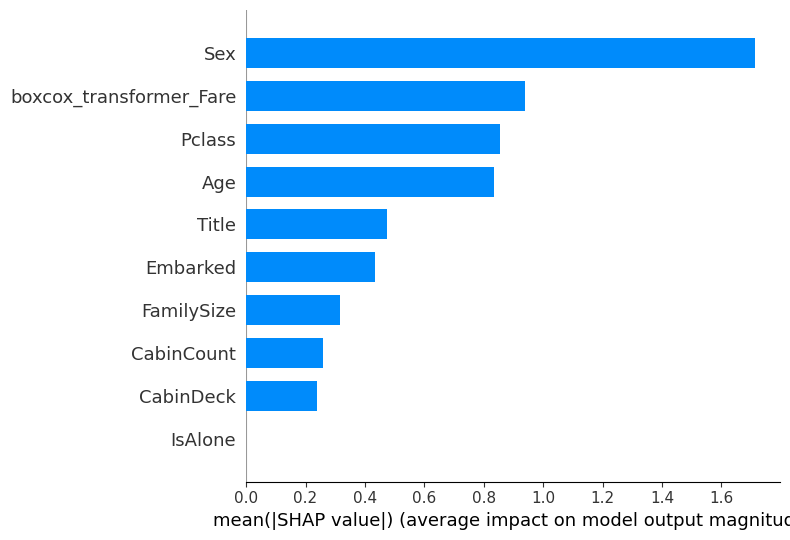

In [30]:
# Plot feature importance for engineered model with GPU optimization
explainer = shap.Explainer(best_model, df_eng_train[top_features_final])
shap_values = explainer(df_eng_val[top_features_final])
print(f"\nSHAP Summary Plot (Top {len(top_features_final)} Features):")
shap.summary_plot(shap_values, df_eng_val[top_features_final], plot_type="bar", max_display=len(top_features_final))


SHAP with Baseline Model Summary Plot:


C:\Users\arthu\AppData\Local\Temp\ipykernel_12996\31831234.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=len(top_features_final))


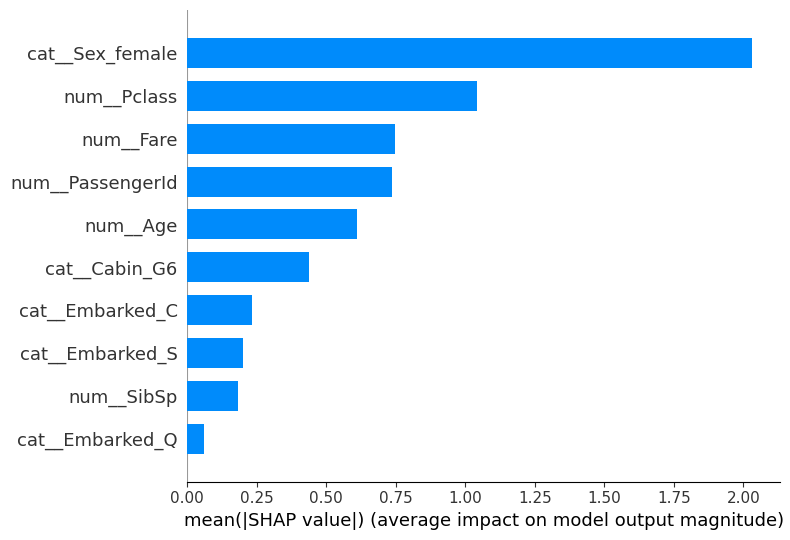

In [31]:
# Plot feature importance for baseline model
explainer = shap.Explainer(baseline_model, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=len(top_features_final))

In [32]:
print("\n--- Model Performance Comparison ---")
# Make sure you have the baseline_accuracy variable from the start of your notebook
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}") 
print(f"Final Model Accuracy:    {best_accuracy:.4f}")
print("------------------------------------")


--- Model Performance Comparison ---
Baseline Model Accuracy: 0.7263
Final Model Accuracy:    0.8212
------------------------------------


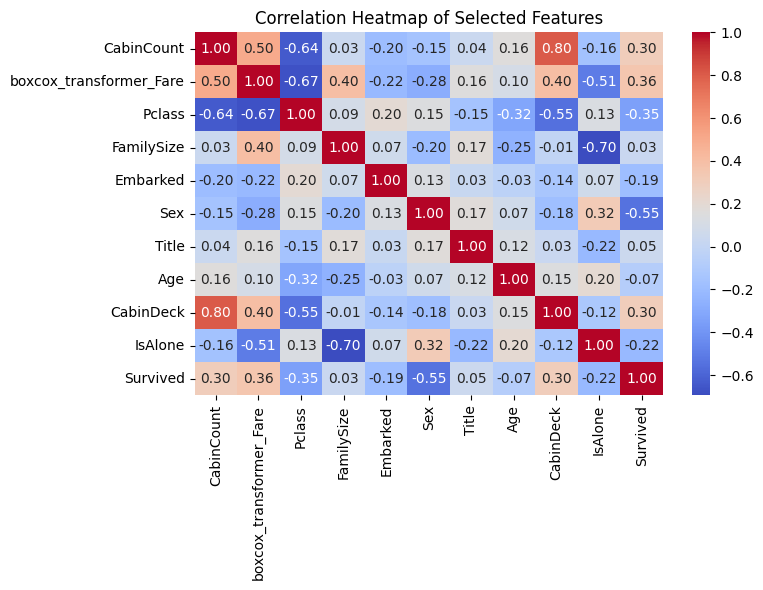

In [33]:
# Show correlation heatmap of the selected features
try:
    plt.figure(figsize=(8, 6))
    # Ensure all features exist in the dataframe
    available_features = [f for f in top_features_final if f in df_eng_train.columns]
    if len(available_features) < len(top_features_final):
        print(f"Warning: Some features not found. Using {len(available_features)} out of {len(top_features_final)} features.")
    
    corr_matrix = df_eng_train[available_features + ['Survived']].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Heatmap of Selected Features')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating correlation heatmap: {e}")
    print("Skipping correlation heatmap...")

## Optimizing Feature Engineered Model

In [34]:
# Optimize using cross-validation
print("Starting cross-validation hyperparameter optimization...")
study_cv = opt.create_study(direction='minimize')
study_cv.optimize(
    lambda trial: objective_cv(trial, X_train_eng_subset, y_train_eng), 
    n_trials=200  # Reduced trials since CV takes longer
)

print("\nBest hyperparameters found with CV:")
print(study_cv.best_params)
print(f"\nBest CV accuracy: {-study_cv.best_value:.4f}")

[I 2025-09-29 22:23:17,356] A new study created in memory with name: no-name-2da9a5c3-2f71-48ce-9ec4-901e661f27c3
[I 2025-09-29 22:23:17,440] Trial 0 finished with value: -0.7837387964148528 and parameters: {'n_estimators': 250, 'learning_rate': 0.010477014542823536, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.7098110398787933, 'colsample_bytree': 0.8499907372186551, 'gamma': 2.01156718478467, 'reg_lambda': 5.475788778075506, 'reg_alpha': 6.318418343290409}. Best is trial 0 with value: -0.7837387964148528.
[I 2025-09-29 22:23:17,509] Trial 1 finished with value: -0.7893627499261302 and parameters: {'n_estimators': 250, 'learning_rate': 0.18887138761095754, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6521993353240286, 'colsample_bytree': 0.6347110480073094, 'gamma': 2.7101336413972583, 'reg_lambda': 2.6649537699532697, 'reg_alpha': 6.137693019913161}. Best is trial 1 with value: -0.7893627499261302.


Starting cross-validation hyperparameter optimization...


[I 2025-09-29 22:23:17,588] Trial 2 finished with value: -0.7936176499556782 and parameters: {'n_estimators': 300, 'learning_rate': 0.04251156549779057, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8326240205616299, 'colsample_bytree': 0.8754265420222445, 'gamma': 2.1972882890319974, 'reg_lambda': 7.097263257679072, 'reg_alpha': 3.3474591331786563}. Best is trial 2 with value: -0.7936176499556782.
[I 2025-09-29 22:23:17,673] Trial 3 finished with value: -0.8076430611641878 and parameters: {'n_estimators': 250, 'learning_rate': 0.05065387359544898, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6978847402535717, 'colsample_bytree': 0.7627010789328881, 'gamma': 0.7736977729099643, 'reg_lambda': 3.0600734400848477, 'reg_alpha': 0.8478696928931551}. Best is trial 3 with value: -0.8076430611641878.
[I 2025-09-29 22:23:17,735] Trial 4 finished with value: -0.8048064611444893 and parameters: {'n_estimators': 150, 'learning_rate': 0.02338405226532979, 'max_depth': 6, 'min_chi


Best hyperparameters found with CV:
{'n_estimators': 50, 'learning_rate': 0.16276440738163991, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7009817032397232, 'colsample_bytree': 0.6246088860565873, 'gamma': 0.7668582667999182, 'reg_lambda': 7.811235481441808, 'reg_alpha': 7.540002034534519}

Best CV accuracy: 0.8259


In [35]:
# Train the final model with CV-optimized hyperparameters and enhanced regularization
engineered_model_cv_tuned = xgb.XGBClassifier(
    n_estimators=study_cv.best_params['n_estimators'],
    learning_rate=study_cv.best_params['learning_rate'],
    max_depth=study_cv.best_params['max_depth'],
    min_child_weight=study_cv.best_params.get('min_child_weight', 3),  # Default regularization
    subsample=study_cv.best_params['subsample'],
    colsample_bytree=study_cv.best_params['colsample_bytree'],
    gamma=study_cv.best_params['gamma'],
    reg_lambda=study_cv.best_params['reg_lambda'],
    reg_alpha=study_cv.best_params['reg_alpha'],
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10  # Add early stopping
)

# Correctly define train and validation sets for this step
y_train_final = df_eng_train['Survived']
y_val_final = df_eng_val['Survived']

# Fit on training data with early stopping
engineered_model_cv_tuned.fit(
    X_train_eng_subset, y_train_final,
    eval_set=[(X_val_eng_subset, y_val_final)],
    verbose=False
)

# Evaluate on validation set
preds_cv_tuned = engineered_model_cv_tuned.predict(X_val_eng_subset)
engineered_cv_tuned_accuracy = accuracy_score(y_val_final, preds_cv_tuned)

# Check for overfitting by comparing train vs validation performance
train_preds_cv = engineered_model_cv_tuned.predict(X_train_eng_subset)
train_accuracy_cv = accuracy_score(y_train_final, train_preds_cv)

print(f"Enhanced CV-Tuned Model Results:")
print(f"   Training Accuracy:   {train_accuracy_cv:.4f}")
print(f"   Validation Accuracy: {engineered_cv_tuned_accuracy:.4f}")
print(f"   Overfitting Gap:     {train_accuracy_cv - engineered_cv_tuned_accuracy:.4f}")

if train_accuracy_cv - engineered_cv_tuned_accuracy < 0.05:
    print("Good generalization - low overfitting!")
elif train_accuracy_cv - engineered_cv_tuned_accuracy < 0.08:
    print("Moderate overfitting - acceptable for small datasets")
else:
    print("High overfitting detected - model may not generalize well")

print(f"Best training iteration: {engineered_model_cv_tuned.best_iteration}")

Enhanced CV-Tuned Model Results:
   Training Accuracy:   0.8301
   Validation Accuracy: 0.7989
   Overfitting Gap:     0.0312
Good generalization - low overfitting!
Best training iteration: 48


In [39]:
# Compare all models
print("\n--- Final Model Performance Comparison ---")
print(f"\nBaseline Model Accuracy:                  {baseline_accuracy:.4f}")
print(f'Baseline Model (CV-Tuned) Accuracy:       {baseline_tuned_accuracy:.4f}')
print('-'*40)
print(f"Final Model (Feature Selection) Accuracy: {best_accuracy:.4f}")
print(f"Final Model (CV-Tuned) Accuracy:          {engineered_cv_tuned_accuracy:.4f}")


--- Final Model Performance Comparison ---

Baseline Model Accuracy:                  0.7263
Baseline Model (CV-Tuned) Accuracy:       0.8156
----------------------------------------
Final Model (Feature Selection) Accuracy: 0.8212
Final Model (CV-Tuned) Accuracy:          0.7989


Possible reasons for the CV-Tuned model having slightly lower validation accuracy than the Feature Selection model:

1. Stronger Regularization

The CV-Tuned model uses cross-validation for optimization, which naturally favors more conservative hyperparameters.
Parameters such as min_child_weight, reg_lambda, and reg_alpha are optimized for generalization, not for maximum accuracy in the validation set. This prevents overfitting at the cost of a small reduction in validation accuracy.

2. Different Optimization Objectives

The Feature Selection model may have been optimized specifically for the validation set, potentially leading to higher accuracy but also a greater risk of overfitting. In contrast, the CV-Tuned model's objective is to perform well across multiple folds, which can result in a more robust model at the expense of peak performance on a single validation set.

-------------

But in the end both models perform similarly, with the CV-Tuned model being slightly more robust due to its cross-validation approach. And the most important, it's possible to visualize the feature engineering impact on the model interpretability when comparing with the baseline model.

---

## References & Resources

### **Technical Documentation:**
- [Scikit-learn Documentation](https://scikit-learn.org/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [SHAP Documentation](https://shap.readthedocs.io/)
- [Optuna Documentation](https://optuna.readthedocs.io/)
- [Professor's GitHub Repository](https://github.com/lseman/foreblocks)

### **Methodological References:**
- Mutual Information for feature selection
- HSIC (Hilbert-Schmidt Independence Criterion)
- Box-Cox transformations for normality
- Winsorization for outlier treatment

### **Academic Context:**
- **Course:** Algoritmos e Estruturas de Dados
- **Institution:** Universidade Federal de Santa Catarina (UFSC)
- **Program:** Pós-graduação

---

*Student: Arthur Gislon Leonida*